In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy import stats
import os

In [5]:
# Define the list of countries and their cleaned data files
countries = ['benin', 'sierraleone', 'togo']
cleaned_data_dir = '../data'
combined_df = pd.DataFrame() # Initialize an empty DataFrame

In [6]:
# Load and combine data for each country
for country in countries:
    file_path = os.path.join(cleaned_data_dir, f'{country}_clean.csv')
    try:
        df_country = pd.read_csv(file_path)
        df_country['Country'] = country.capitalize() # Add a 'Country' column
        combined_df = pd.concat([combined_df, df_country], ignore_index=True)
        print(f"Successfully loaded {file_path}")
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Please ensure the cleaned CSV exists.")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

Successfully loaded ../data\benin_clean.csv
Successfully loaded ../data\sierraleone_clean.csv
Successfully loaded ../data\togo_clean.csv


In [7]:
# Display info about the combined DataFrame
print("\nCombined DataFrame Info:")
combined_df.info()
combined_df.head()


Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576800 entries, 0 to 1576799
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Timestamp           1576800 non-null  object 
 1   GHI                 1576800 non-null  float64
 2   DNI                 1576800 non-null  float64
 3   DHI                 1576800 non-null  float64
 4   ModA                1576800 non-null  float64
 5   ModB                1576800 non-null  float64
 6   Tamb                1576800 non-null  float64
 7   RH                  1576800 non-null  float64
 8   WS                  1576800 non-null  float64
 9   WSgust              1576800 non-null  float64
 10  WSstdev             1576800 non-null  float64
 11  WD                  1576800 non-null  float64
 12  WDstdev             1576800 non-null  float64
 13  BP                  1576800 non-null  int64  
 14  Cleaning            1576800 non-null  in

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,...,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,is_outlier_flagged,Country
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,...,122.1,0.0,998,0,0.0,26.3,26.2,NaN,False,Benin
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,...,0.0,0.0,998,0,0.0,26.3,26.2,NaN,False,Benin
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,...,124.6,1.5,997,0,0.0,26.4,26.2,NaN,False,Benin
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,...,120.3,1.3,997,0,0.0,26.4,26.3,NaN,False,Benin
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,...,113.2,1.0,997,0,0.0,26.4,26.3,NaN,False,Benin


In [8]:
# Calculate mean, median, std dev for key metrics grouped by country
metrics_to_compare = ['GHI', 'DNI', 'DHI']

# Ensure the metrics columns exist before trying to group
available_metrics = [m for m in metrics_to_compare if m in combined_df.columns]

if available_metrics:
    summary_table = combined_df.groupby('Country')[available_metrics].agg(['mean', 'median', 'std'])

    print("\nSummary Statistics by Country:")
    print(summary_table)
else:
    print("\nKey metric columns (GHI, DNI, DHI) not found in combined data.")



Summary Statistics by Country:
                    GHI                            DNI                     \
                   mean median         std        mean median         std   
Country                                                                     
Benin        240.559452    1.8  331.131327  167.187516   -0.1  261.710501   
Sierraleone  201.957515    0.3  298.495150  116.376337   -0.1  218.652659   
Togo         230.555040    2.1  322.532347  151.258469    0.0  250.956962   

                    DHI                     
                   mean median         std  
Country                                     
Benin        115.358961    1.6  158.691074  
Sierraleone  113.720571   -0.1  158.946032  
Togo         116.444352    2.5  156.520714  


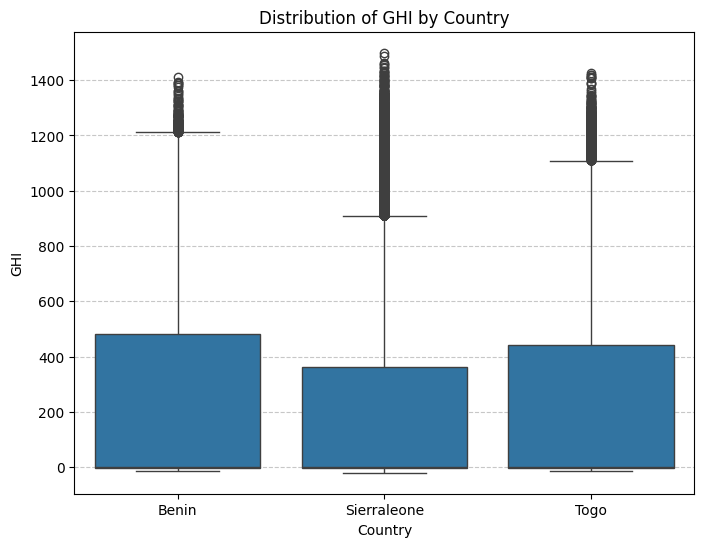

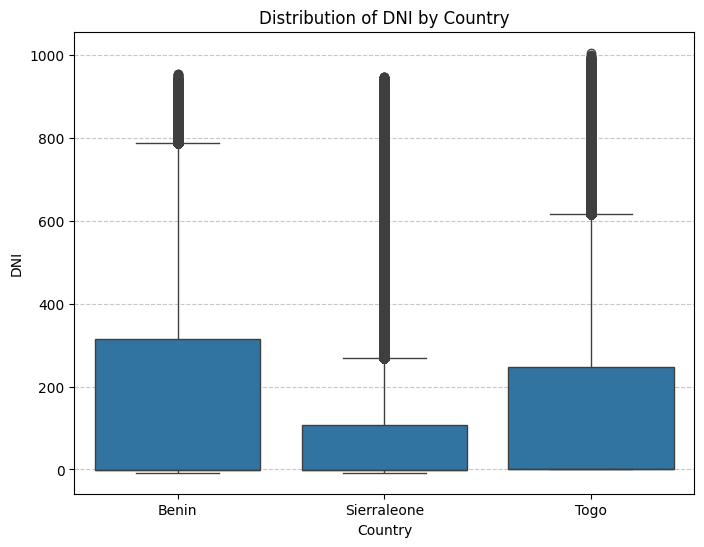

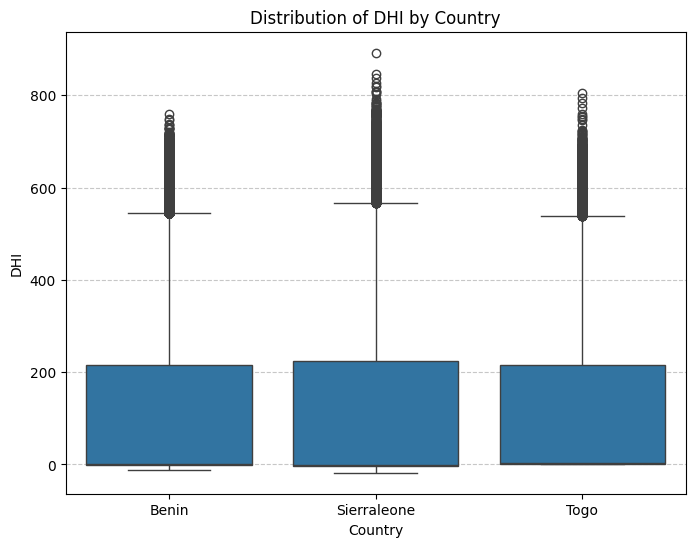

In [9]:
# Create boxplots for each metric, colored by country
if available_metrics:
    for metric in available_metrics:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='Country', y=metric, data=combined_df)
        plt.title(f'Distribution of {metric} by Country')
        plt.ylabel(metric)
        plt.xlabel('Country')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
else:
     print("\nSkipping boxplot generation: Key metric columns not available.")


In [10]:
# Perform ANOVA on GHI values
if 'GHI' in combined_df.columns and len(countries) > 2: # ANOVA requires at least 3 groups
    # Extract GHI values for each country
    ghi_data_by_country = [combined_df[combined_df['Country'] == country.capitalize()]['GHI'].dropna() for country in countries]

    # Remove empty arrays if any country had no GHI data after cleaning/loading
    ghi_data_by_country = [arr for arr in ghi_data_by_country if len(arr) > 0]

    if len(ghi_data_by_country) >= 3: # Re-check if enough groups remain
        # Perform one-way ANOVA
        f_statistic, p_value = stats.f_oneway(*ghi_data_by_country)

        print("\nANOVA Test on GHI:")
        print(f"F-statistic: {f_statistic:.4f}")
        print(f"P-value: {p_value:.4f}")

        # Interpretation
        alpha = 0.05 # Common significance level
        if p_value < alpha:
            print(f"Result: The p-value ({p_value:.4f}) is less than {alpha}. There is a statistically significant difference in mean GHI between the countries.")
        else:
            print(f"Result: The p-value ({p_value:.4f}) is not less than {alpha}. We do not have sufficient evidence to say there is a statistically significant difference in mean GHI between the countries.")

    elif len(ghi_data_by_country) > 0: # Not enough groups for ANOVA, but some data exists
         print("\nSkipping ANOVA: Need data for at least 3 countries.")
    else:
         print("\nSkipping ANOVA: No GHI data available for any country.")

elif 'GHI' not in combined_df.columns:
    print("\nSkipping ANOVA: GHI column not found.")
else:
    print("\nSkipping ANOVA: Need data for at least 3 countries for ANOVA.")


ANOVA Test on GHI:
F-statistic: 2090.0929
P-value: 0.0000
Result: The p-value (0.0000) is less than 0.05. There is a statistically significant difference in mean GHI between the countries.


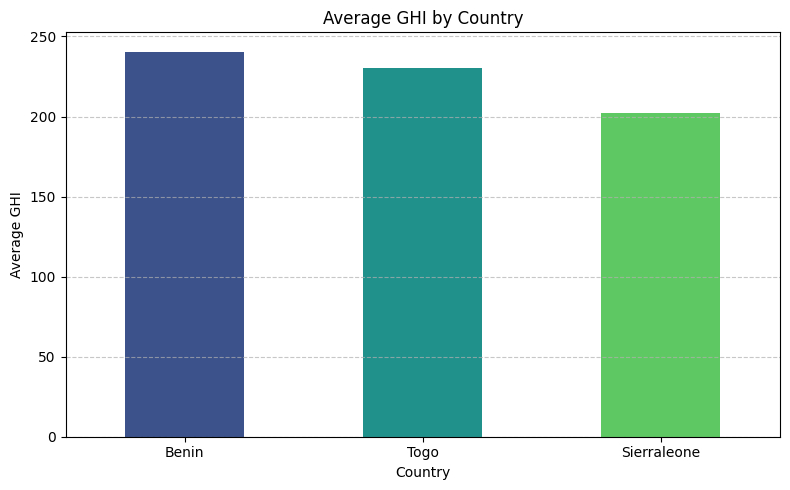

In [11]:
# Calculate average GHI per country
if 'GHI' in combined_df.columns:
    avg_ghi_by_country = combined_df.groupby('Country')['GHI'].mean().sort_values(ascending=False)

    # Create a bar chart
    plt.figure(figsize=(8, 5))
    avg_ghi_by_country.plot(kind='bar', color=sns.color_palette('viridis', len(countries)))
    plt.title('Average GHI by Country')
    plt.xlabel('Country')
    plt.ylabel('Average GHI')
    plt.xticks(rotation=0) # Keep country names horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping bonus bar chart: GHI column not available.")